### Saldías et al. Figure 04

In [1]:
from brokenaxes import brokenaxes
import cmocean as cmo
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib.patches as patches
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import pickle
import scipy as sc
import scipy.io as sio
import seawater as sw
from scipy.interpolate import griddata
import xarray as xr

%matplotlib inline

In [2]:
def plot_isopyc_AS(ax, z, y, rho, rho_min=27.4, rho_max=28.3):
    '''y : y-section to plot, shape is (yslice, xi)
       z : z-section to plot, shape is (nt, zslice, yslice, xi)
       rho: y-z section of density, shape is (nt, zslice, yslice, xi)'''
    Y = np.expand_dims(y,axis=0)
    Z = np.squeeze(z)
    Y = Y + np.zeros_like(Z)
    cn = ax.contour(((y/1E3-400)), z, rho, levels=np.linspace(rho_min, rho_max, 28), colors='k')
    ax.contour(((y/1E3-400)), z, rho, levels=[27.6, 27.8, 28.0, 28.2],colors='yellow')
    return(ax, cn)

def plot_dens_AS(ax, z, y, rho, rho_min=27.4, rho_max=28.3):
    '''y : y-section to plot, shape is (yslice, xi)
       z : z-section to plot, shape is (nt, zslice, yslice, xi)
       rho: y-z section of density, shape is (nt, zslice, yslice, xi)'''
    ax.set_facecolor('tan')
    pc2 = ax.contourf((y/1E3-400), z, rho, 25, cmap=cmo.cm.tarn, vmin=rho_min, vmax=rho_max)
    return(ax, pc2)

def plot_dens_bott(ax, x, y, rho, rho_min=27, rho_max=27.5):
    '''y : y-section to plot, shape is (yslice, xslice)
       x : x-section to plot, shape is (yslice, xslice)
       rho: x-y section of density, shape is (nt, yslice, xslice)'''
    ax.set_facecolor('white')
    pc2 = ax.contourf((x/1E3-400),(y/1E3-400), rho, 35, cmap=cmo.cm.tarn,
                      vmin=rho_min, vmax=rho_max)
    return(ax, pc2)

def plot_isopyc_rho(ds, ds_nc, ax_avg, ax_low, ax_high, t1, t2, t_low, t_high, 
                    y1, y2, x1, rho_min=27.4, rho_max=28.3, thresh = -100):
    '''Plot alongshore sections of density difference (canyon-no canyon)'''
    time = ds.ocean_time[:]/(3600*24)
    
    Y, Z, rho_high = interp_rho(ds,y1,y2,x1,t_high,0,thresh=thresh)
    Ync, Znc, rho_high_nc = interp_rho(ds_nc,y1,y2,x1,t_high,0,thresh=thresh, bathy_flag='no canyon')
    ax_high, cn = plot_dens_AS(ax_high, Znc, Ync, 
                               rho_high-rho_high_nc, 
                               rho_min=rho_min, rho_max=rho_max)
    ax_high.invert_xaxis()

    Y, Z, rho_low = interp_rho(ds,y1,y2,x1,t_low,0,thresh=thresh)
    Ync, Znc, rho_low_nc = interp_rho(ds_nc,y1,y2,x1,t_low,0,thresh=thresh, bathy_flag='no canyon') 
    ax_low, cn = plot_dens_AS(ax_low, Znc, Ync, 
                              rho_low-rho_low_nc, 
                              rho_min=rho_min, rho_max=rho_max)
    ax_low.invert_xaxis()

    Y, Z, rho_avg = interp_rho(ds,y1,y2,x1,t1,t2,thresh=thresh, avg=True)
    Ync, Znc, rho_avg_nc = interp_rho(ds_nc,y1,y2,x1,t1,t2,thresh=thresh, avg=True, bathy_flag='no canyon') 
    ax_avg, cn = plot_dens_AS(ax_avg, Znc, Ync, 
                              rho_avg-rho_avg_nc, 
                              rho_min=rho_min, rho_max=rho_max)
    ax_avg.invert_xaxis()

    cmap = cmo.cm.tarn
    norm = mpl.colors.BoundaryNorm(np.linspace(rho_min,rho_max,25), cmap.N)
    cbar_ax = fig.add_axes([0.91, 0.123, 0.025, 0.332])
    cb2 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical', format='%1.2f', 
                                    label=r'$\Delta \rho$ (kg m$^{-3}$)')
    ax_high.set_ylim(thresh,-2)
    ax_low.set_ylim(thresh,-2)
    ax_avg.set_ylim(thresh,-2)
    
    
def plot_rho_bott(ds, ds_nc, ax_avg, ax_low, ax_high, t1, t2, t_low, t_high, 
                  y1, y2, x1, xend, canyon_mask, nocanyon_mask, rho_min=27.4, rho_max=28.3):
    '''Plot bottom density difference between canyon and no canyon runs (mean, low and high phases)'''
    y = ds.y_rho[y1:y2,x1:xend].data
    x = ds.x_rho[y1:y2,x1:xend].data  
    
    with open('box_rho_IS.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
        rho_box, rho_box_nc, time = pickle.load(f)
     
    # High 
    rho_high = np.ma.masked_array(rho_box[t_high,0,:,:], mask=canyon_mask)
    rho_high_nc = np.ma.masked_array(rho_box_nc[t_high,0,:,:], mask=nocanyon_mask)
        
    rho_0 = 0.
    rho_nc_0 = 0.
    
    ax_high, cn = plot_dens_bott(ax_high, x, y, (rho_high-rho_0)-(rho_high_nc-rho_nc_0), 
                                 rho_min=rho_min, rho_max=rho_max)
    ax_high.contour((x/1000)-400,(y/1000)-400,ds.h[y1:y2,x1:xend].data,levels=[150], colors='k')
    
    # Low
    rho_low = np.ma.masked_array(rho_box[t_low,0,:,:], mask=canyon_mask)
    rho_low_nc = np.ma.masked_array(rho_box_nc[t_low,0,:,:], mask=nocanyon_mask)

    ax_low, cn = plot_dens_bott(ax_low, x, y, (rho_low-rho_0)-(rho_low_nc-rho_nc_0), 
                                rho_min=rho_min, rho_max=rho_max)
    ax_low.contour((x/1000)-400,(y/1000)-400,ds.h[y1:y2,x1:xend].data,levels=[150], colors='k')
    
    # Avg
    rho_slice_nc = np.ma.masked_array(np.nanmean(rho_box_nc[t1:t2,0,:,:],axis=0), mask=nocanyon_mask)
    rho_slice = np.ma.masked_array(np.nanmean(rho_box[t1:t2,0,:,:],axis=0), mask=canyon_mask)
        
    rho_avg = rho_slice-rho_slice_nc
    ax_avg, cn = plot_dens_bott(ax_avg, x, y, rho_avg,
                                rho_min=rho_min, rho_max=rho_max)
    ax_avg.contour((x/1000)-400,(y/1000)-400,ds.h[y1:y2,x1:xend].data,levels=[150], colors='k')
    
    ax_avg.set_aspect(0.3)
    ax_high.set_aspect(0.3)
    ax_low.set_aspect(0.3)

def mean_rho_shelf(ds, y1, y2, xind, xend, thresh=-150, bathy_flag='canyon'):
    '''Calculate volume-weighted mean density on the shelf'''
    
    mask = np.ma.getmask(np.ma.masked_less_equal(ds.z_rho[:,:,y1:y2,xind:xend],thresh))

    with open('box_rho_'+run+'.pkl', 'rb') as f:  
        rho_box, rho_box_nc, time = pickle.load(f)
    if bathy_flag == 'no canyon':
        rho_shelf = np.ma.masked_array(rho_box_nc, mask=mask)
    else:     
        rho_shelf = np.ma.masked_array(rho_box, mask=mask)
        
    #x-spacing
    dx =  np.expand_dims(np.expand_dims(np.expand_dims(ds.x_u[y1,xind:xend].data-
                                        ds.x_u[y1,xind-1:xend-1].data,axis=0), axis=0),axis=0)
    dx_exp = dx + np.zeros_like(rho_shelf)
    
    #y-spacing
    dy =  np.expand_dims(np.expand_dims(np.expand_dims(ds.y_u[y1-1:y2-1,xind].data-
                                        ds.y_u[y1:y2,xind].data,axis=1), axis=0), axis=0)
    dy_exp = dy + np.zeros_like(rho_shelf)
    
    #z-spacing
    dz = -(ds.z_w[:,:-1,y1:y2,xind:xend].data-ds.z_w[:,1:,y1:y2,xind:xend].data)
                                    
    # cell volumes
    dv = dx_exp * dy_exp * dz
    
    # volume-weighted avg
    rho_avg = (np.nansum(np.nansum(np.nansum(dv*rho_shelf, axis=1),axis=1),axis=1)/
               np.nansum(np.nansum(np.nansum(dv, axis=1), axis=1),axis=1))
    return(rho_avg)
    
def calc_delta_rho(ds, ds_nc, y1, y2, xind, xend):
    '''Calculate \delta rho on shelf (canyon - no canyon)'''
    rho_canyon = mean_rho_shelf(ds,y1, y2, xind, xend, thresh=-150)  
    rho_nocan = mean_rho_shelf(ds_nc,y1, y2, xind, xend, thresh=-150, bathy_flag='no canyon')                                   
    return((rho_canyon-rho_nocan)-(rho_canyon-rho_nocan)[0])


def interp_rho(ds,y1,y2,xind,tt,tt2,thresh=-75,ny=300,nz=30, avg=False, bathy_flag='canyon'):
    '''Interpolate alongshore section to a regular Y-Z grid'''
    
    with open('box_rho_IS.pkl', 'rb') as f:  
        rho_box, rho_box_nc, time = pickle.load(f)
    if bathy_flag == 'no canyon':
        rho_shelf = rho_box_nc
    else:     
        rho_shelf = rho_box
    
    if avg == True:
        Zp1 = np.squeeze(np.nanmean(ds.z_rho[tt:tt2,:,y1:y2,xind], axis=0))
        Rp1 = np.squeeze(np.nanmean(rho_shelf[tt:tt2,:,:,xind-188], axis=0))
    else:
        Zp1 = np.squeeze(ds.z_rho[tt,:,y1:y2,xind])
        Rp1 = np.squeeze(rho_shelf[tt,:,:,xind-188])

    Yp1 = np.expand_dims(ds.y_rho[y1:y2,xind], axis=0) + np.zeros_like(Zp1)
    
    Zp = np.reshape(Zp1.data,(y2-y1)*30)
    Yp = np.reshape(Yp1.data,(y2-y1)*30)
    Rp = np.reshape(Rp1.data,(y2-y1)*30)

    y = np.linspace(ds.y_rho[y1,0],ds.y_rho[y2,0],ny)
    z =  np.linspace(thresh,0,nz)
    Y, Z = np.meshgrid(y,z)
    R = griddata((Yp, Zp), Rp, (Y, Z), method='cubic')

    return(Y,Z,R)


In [3]:
runs = ['DS','IS','SS']
titles = ['Period-averaged','Low sea level','High sea level']

col1 = '#254441' 
col2 = '#43AA8B' 
col3 = '#B2B09B' 
colors = [col1, col2, col3]

In [4]:
file = '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_CR_IS_7d.nc'
ds = xr.open_dataset(file, decode_times=False)

file2 = '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_NCR_IS_7d.nc'
ds_nc = xr.open_dataset(file2, decode_times=False)

/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


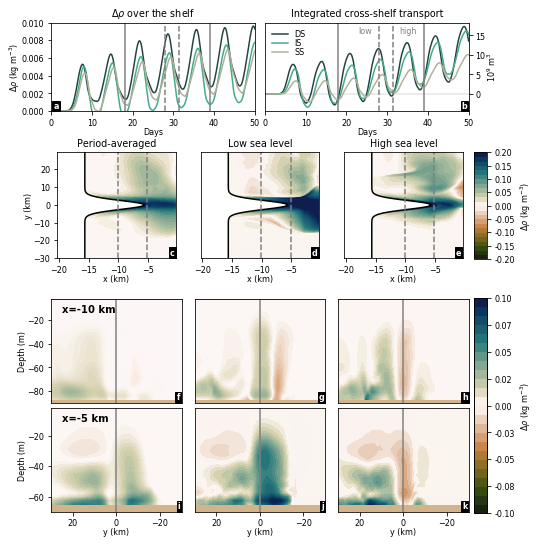

In [5]:
fig = plt.figure(figsize=(7.48,9))
plt.rcParams.update({'font.size': 8})

# Set up subplot grid
gs = gspec.GridSpec(3, 1, height_ratios=[0.25,0.3,0.6],
              wspace=0.1,hspace=0.3, figure=fig)

gs0 = gspec.GridSpecFromSubplotSpec(1,2,subplot_spec=gs[0,0],
                                       wspace=0.05,width_ratios=[1,1])
gs1 = gspec.GridSpecFromSubplotSpec(1,3,subplot_spec=gs[1,0],
                                       wspace=0.1,width_ratios=[1,1,1])
gs2 = gspec.GridSpecFromSubplotSpec(2,3,subplot_spec=gs[2,0],
                                       hspace=0.05,wspace=0.1,width_ratios=[1,1,1])

ax1 = fig.add_subplot(gs0[0, 0])
ax2 = fig.add_subplot(gs0[0, 1])
ax3 = fig.add_subplot(gs1[0, 0])
ax4 = fig.add_subplot(gs1[0, 1])
ax5 = fig.add_subplot(gs1[0, 2])
ax6 = fig.add_subplot(gs2[0, 0])
ax7 = fig.add_subplot(gs2[0, 1])
ax8 = fig.add_subplot(gs2[0, 2])
ax9 = fig.add_subplot(gs2[1, 0])
ax10 = fig.add_subplot(gs2[1, 1])
ax11 = fig.add_subplot(gs2[1, 2])

for ax in [ax4,ax5,ax7,ax8,ax10,ax11]:
    ax.set_yticks([])

for ax,title in zip([ax3,ax4,ax5],titles):
    ax.set_xlabel('x (km)', labelpad=0)
    ax.set_title(title)
for ax in [ax6, ax7, ax8]:
    ax.set_xticks([])
for ax in [ax9,ax10,ax11]:
    ax.set_xlabel('y (km)', labelpad=0)

ax1.set_ylabel(r'$\Delta \rho$ (kg m$^{-3}$)', labelpad=0)
ax1.set_title(r'$\Delta \rho$ over the shelf')
ax1.set_xlabel('Days', labelpad=0)
ax2.set_ylabel(r'$10^9$ m$^{3}$', labelpad=0)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_title('Integrated cross-shelf transport')
ax2.set_xlabel('Days', labelpad=0)
ax3.set_ylabel('y (km)', labelpad=0)
ax9.set_ylabel('Depth (m)', labelpad=0)
ax6.set_ylabel('Depth (m)', labelpad=0)

# Integrated transport
file = '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_CR_IS_7d.nc'
ds = xr.open_dataset(file, decode_times=False)
file2 = '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_NCR_IS_7d.nc'
ds_nc = xr.open_dataset(file2, decode_times=False)

ax2.axhline(0, color='0.9')
with open('../cs_integrated_transport.pkl', 'rb') as f:  
    transDS, transIS, transSS, time  = pickle.load(f)
ax2.plot(time, transDS/1E9, label='DS', color=col1)
ax2.plot(time, transIS/1E9, label='IS', color=col2)
ax2.plot(time, transSS/1E9, label='SS', color=col3)
ax2.set_xlim(0,50)
ax2.legend(labelspacing=0,edgecolor='w')    

## Density alongshore sections
y1 = 139 # -30 km canyon axis
y2 = 439 # +30 km canyon axix 
y_axis = 289 # canyon axis
x1 = 239 # -10 km
x2 = 264 # -5 km
x3 = 188
xend = 289
t1 = 90
t2 = 195
t_low = 140
t_high = 157

# Plotting max and min
rho_min = -0.2
rho_max = 0.2
rho_min2 = -0.1
rho_max2 = 0.1

ax2.axvline(time[t_high], linestyle='--', color='0.5')
ax2.axvline(time[t_low], linestyle='--', color='0.5')
ax2.text(33,15.5,'high', color='0.5')
ax2.text(23,15.5,'low', color='0.5')
ax2.axvline(time[t1], linestyle='-', color='0.5')
ax2.axvline(time[t2], linestyle='-', color='0.5')

canyon_mask = np.ma.getmask(np.ma.masked_greater_equal(ds.h[y1:y2,x3:xend],150))
nocanyon_mask = np.ma.getmask(np.ma.masked_greater_equal(ds_nc.h[y1:y2,x3:xend],150))

plot_rho_bott(ds,ds_nc,ax3,ax4,ax5,t1,t2,t_low,t_high,y1,y2,x3,xend,canyon_mask,nocanyon_mask, 
              rho_min=rho_min, rho_max=rho_max)

cmap = cmo.cm.tarn
norm = mpl.colors.BoundaryNorm(np.linspace(rho_min,rho_max,25), cmap.N)
cbar_ax = fig.add_axes([0.91, 0.515, 0.025, 0.165])
cb2 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical', format='%1.2f')
cb2.set_label(r'$\Delta \rho$ (kg m$^{-3}$)')
plot_isopyc_rho(ds,ds_nc,ax6,ax7,ax8,t1,t2,t_low,t_high,y1,y2,x1,
                rho_min=rho_min2, rho_max=rho_max2,thresh=-90)
plot_isopyc_rho(ds,ds_nc,ax9,ax10,ax11,t1,t2,t_low,t_high,y1,y2,x2,
                rho_min=rho_min2, rho_max=rho_max2,thresh=-70)

ax6.text(25,-13.0,'x=-10 km', color='k', fontsize=10, fontweight='bold')
ax9.text(25,-11.0,'x=-5 km', color='k', fontsize=10, fontweight='bold')


# ##Delta rho time series
for run, col in zip(runs, colors):
    with open('delta_rho_shelf_wa_'+run+'.pkl', 'rb') as f:  
        delta_rho, time = pickle.load(f)
        ax1.plot(time, delta_rho, color=col)
    
ax1.axvline(time[t_high], linestyle='--', color='0.5')
ax1.axvline(time[t_low], linestyle='--', color='0.5')
ax1.axvline(time[t1], linestyle='-', color='0.5')
ax1.axvline(time[t2], linestyle='-', color='0.5')
ax1.set_xlim(0,50)
ax1.set_ylim(0,0.01)

ax3.axvline((ds.x_rho[0,x1]/1000)-400, linestyle='--', color='0.5')
ax3.axvline((ds.x_rho[0,x2]/1000)-400, linestyle='--', color='0.5')
ax4.axvline((ds.x_rho[0,x1]/1000)-400, linestyle='--', color='0.5')
ax4.axvline((ds.x_rho[0,x2]/1000)-400, linestyle='--', color='0.5')
ax5.axvline((ds.x_rho[0,x1]/1000)-400, linestyle='--', color='0.5')
ax5.axvline((ds.x_rho[0,x2]/1000)-400, linestyle='--', color='0.5')

ax6.axvline(0, color='0.5')
ax7.axvline(0, color='0.5')
ax8.axvline(0, color='0.5')
ax9.axvline(0, color='0.5')
ax10.axvline(0, color='0.5')
ax11.axvline(0, color='0.5')

ax1.text(0.01,0.03,'a',transform=ax1.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})
ax2.text(0.965,0.03,'b',transform=ax2.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})
ax3.text(0.95,0.03,'c',transform=ax3.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})
ax4.text(0.94,0.03,'d',transform=ax4.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})
ax5.text(0.94,0.03,'e',transform=ax5.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})
ax6.text(0.96,0.03,'f',transform=ax6.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})
ax7.text(0.95,0.03,'g',transform=ax7.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})
ax8.text(0.95,0.03,'h',transform=ax8.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})
ax9.text(0.97,0.03,'i',transform=ax9.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})
ax10.text(0.97,0.03,'j',transform=ax10.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})
ax11.text(0.95,0.03,'k',transform=ax11.transAxes, fontsize=8, fontweight='bold',
         color='w', bbox={'facecolor': 'black', 'alpha': 1, 'pad': 1})

plt.savefig('Figure4.png',format='png',bbox_inches='tight', dpi=300)
plt.show()